In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import math
import random
device='cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-1-30a41f0dc109>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'cuda'

In [2]:
MODEL_NAME="google/vit-large-patch16-224-in21k"
BATCH_SIZE=64

In [3]:
train_metadata_path = "/kaggle/input/BDMA7_project_files/train_metadata.csv"  # Path to the metadata file
train_images_dir = "/kaggle/input/BDMA7_project_files/train_images"           # Path to training images directory

val_metadata_path = "/kaggle/input/BDMA7_project_files/val_metadata.csv"      # Path to validation metadata file
val_images_dir = "/kaggle/input/BDMA7_project_files/val_images"               # Path to validation images directory

test_images_dir = Path("/kaggle/input/BDMA7_project_files/test_images/mistery_cat")

In [4]:
df_train = pd.read_csv(train_metadata_path)
df_train["path"] = train_images_dir + "/" + df_train["path"]

df_val = pd.read_csv(val_metadata_path)
df_val["path"] = val_images_dir + "/" + df_val["path"]

df_test = pd.DataFrame(
    data = {
    "path": [str(path) for path in test_images_dir.glob("*.jpg")]
    }
)

df_train

,path,class,class_idx
0,/kaggle/input/BDMA7_project_files/train_images...,Brandt_Cormorant,4
1,/kaggle/input/BDMA7_project_files/train_images...,Brandt_Cormorant,4
2,/kaggle/input/BDMA7_project_files/train_images...,Brandt_Cormorant,4
3,/kaggle/input/BDMA7_project_files/train_images...,Brandt_Cormorant,4
4,/kaggle/input/BDMA7_project_files/train_images...,Brandt_Cormorant,4
...,...,...,...
1077,/kaggle/input/BDMA7_project_files/train_images...,Gray_Catbird,3
1078,/kaggle/input/BDMA7_project_files/train_images...,Gray_Catbird,3
1079,/kaggle/input/BDMA7_project_files/train_images...,Gray_Catbird,3
1080,/kaggle/input/BDMA7_project_files/train_images...,Gray_Catbird,3


<BarContainer object of 20 artists>

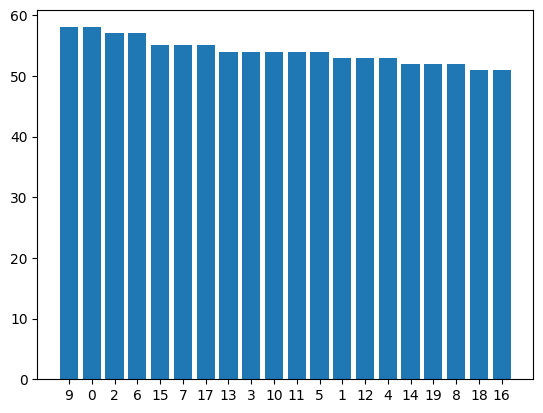

In [5]:
class_counts=df_train["class_idx"].value_counts()
plt.bar(class_counts.index.astype(str), class_counts)

In [6]:
def read_image(path, transform=None):
    if not os.path.isfile(path):  # Check if file exists
        raise FileNotFoundError(f"Image not found: {path}")
    
    # image = Image.open(path).convert("RGB")  # Open as RGB
    image = torchvision.io.read_image(path)
    if transform:
        image = transform(image)  # Apply transformations
    return image

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.v2.RandomResizedCrop(size=(224, 224), scale=(0.3,0.7)),
    transforms.ColorJitter(brightness=0.5, contrast= 0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.v2.RandomZoomOut(fill=0, side_range=(1.0, 4.0)),
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half()
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half()
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [7]:
# image=read_image("/kaggle/input/bdma-compatition/BDMA7_project_files/train_images/Brandt_Cormorant/Brandt_Cormorant_0074_22881.jpg", transform=transform)
# plt.imshow(image.squeeze(0).permute(1,2,0))

In [8]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, imgs_labels=None, transform=None):
        super().__init__()
        self.imgs_paths = imgs_paths
        self.imgs_labels = imgs_labels
        self.transform = transform

    def __getitem__(self, idx):
        #print(f"Loading image: {self.imgs_paths.iloc[idx]}") 
        image = read_image(self.imgs_paths.iloc[idx], self.transform)
        if self.imgs_labels is None:
            return image
        else:
            label = self.imgs_labels.iloc[idx]
            return image, label

    def __getitems__(self, indices):
        images=self.imgs_paths.iloc[indices].apply(lambda path: read_image(path, self.transform))
        if self.imgs_labels is None:
            return images.to_list()
        else:
            labels = self.imgs_labels.iloc[indices]
            return images.to_list(), labels.to_list()

    def __len__(self):
        return len(self.imgs_paths)

In [9]:
train_dataset = BirdDataset(imgs_paths = df_train["path"], imgs_labels = df_train["class_idx"], transform = augmentation_transform)
print(f"train loaded {len(train_dataset)}")
val_dataset = BirdDataset(imgs_paths = df_val["path"], imgs_labels = df_val["class_idx"], transform = transform)
print(f"val loaded {len(val_dataset)}")
test_dataset = BirdDataset(imgs_paths = df_test["path"], transform = transform)
print(f"test loaded {len(test_dataset)}")

train loaded 1082
val loaded 103
test loaded 400


In [10]:
def collate_function(batch):
    if len(batch)==2:
        x, y = batch
        return torch.stack(x), torch.tensor(y)
    else:
        return torch.stack(batch)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 4, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)

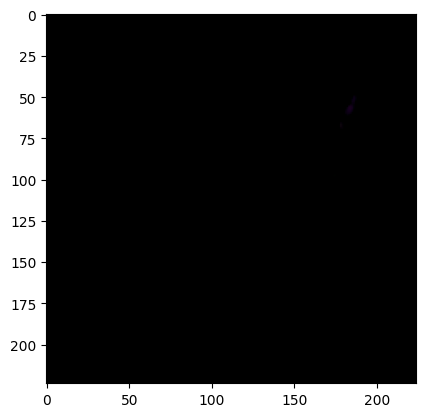

In [12]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0).float())

In [13]:
num_classes = df_train["class_idx"].nunique()
print(f"num_classes = {num_classes}")

num_classes = 20


In [14]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        # self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit = ViTModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        hidden = self.vit(pixel_values=x)
        cls_token = hidden.last_hidden_state[:, 0]
        return self.classifier(cls_token)

model = ViTClassifier(num_classes).to(device)
model=model.half()

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [15]:
# def update_dropout(model, new_dropout):
#     for child_name, child in model.named_children():
#         # If the child is a Dropout layer, update its dropout value
#         if isinstance(child, nn.Dropout):
#             child.p = new_dropout
#         # If the child is a container/module, recursively update its children
#         else:
#             update_dropout(child, new_dropout)

# update_dropout(model, new_dropout=0.2)

In [16]:
def accuracy_fn(logits, labels):
    y_probs=F.softmax(logits, dim=-1)
    y_preds=y_probs.argmax(dim=-1)
    accuracy=(y_preds==labels).sum()/len(labels)
    return accuracy

def soft_cross_entropy(output, target, loss_lams):
    target_prob = torch.zeros_like(output)
    batch = output.shape[0]
    for k in range(batch):
        target_prob[k] = loss_lams[target[k]]
    log_like = -torch.nn.functional.log_softmax(output, dim=1)
    loss = torch.sum(torch.mul(log_like, target_prob)) / batch 
    return loss

def update_loss_lams(output, target, cur_epoch_lams, cur_epoch_cnt):
    with torch.no_grad():
        logits = torch.softmax(output, dim=1)
        sort_args = torch.argsort(logits, dim=1, descending=True)
        for k in range(output.shape[0]):
            if target[k] != sort_args[k, 0]:
                continue
            cur_epoch_lams[target[k]] += logits[k]
            cur_epoch_cnt[target[k]] += 1
    return cur_epoch_lams, cur_epoch_cnt

In [17]:
num_epochs = 100
max_lr=1e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=max_lr, eps=1e-04)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

accuracies_g=[]
train_losses_g=[]
val_losses_g=[]
best_validation=1e9

loss_lams = torch.zeros(num_classes, num_classes, dtype=torch.float32).cuda()

for epoch in range(num_epochs):
    cur_epoch_lams = torch.zeros(num_classes, num_classes, dtype=torch.float32).cuda()
    cur_epoch_cnt = torch.zeros(num_classes, dtype=torch.float32).cuda()
    
    model.train()
    accuracies = []
    train_losses = []
    val_losses = []

    for batch, labels in tqdm(train_loader):
        batch, labels = batch.to(device), labels.to(device)
        logits = model(batch)

        cur_epoch_lams, cur_epoch_cnt = update_loss_lams(logits, labels, cur_epoch_lams, cur_epoch_cnt)
        loss = soft_cross_entropy(logits, labels, loss_lams) * 1.0 + criterion(logits, labels) * 1.0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

    for cls in range(num_classes):
        if cur_epoch_cnt[cls].max() < 0.5:
            loss_lams[cls] = 1. / num_classes
        else:
            loss_lams[cls] = cur_epoch_lams[cls] / cur_epoch_cnt[cls]

    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(val_loader):
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)
            loss = criterion(logits, labels)
            accuracy = accuracy_fn(logits, labels)

            accuracies.append(accuracy.item())
            val_losses.append(loss.item())

    
    accuracies_g.append(torch.tensor(accuracies).mean().item())
    train_losses_g.append(torch.tensor(train_losses).mean().item())
    val_losses_g.append(torch.tensor(val_losses).mean().item())
    print(f"Epoch: {epoch}, train_loss: {train_losses_g[-1]}, val_loss: {val_losses_g[-1]}, accuracy: {accuracies_g[-1]}")
    
    if best_validation>val_losses_g[-1]:
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        best_validation=val_losses_g[-1]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0, train_loss: 2.995634078979492, val_loss: 2.9453125, accuracy: 0.0625


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, train_loss: 5.997931957244873, val_loss: 2.943359375, accuracy: 0.0625


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2, train_loss: 6.006204128265381, val_loss: 2.9404296875, accuracy: 0.0625


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3, train_loss: 5.983685493469238, val_loss: 2.9345703125, accuracy: 0.0703125


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4, train_loss: 5.988970756530762, val_loss: 2.92578125, accuracy: 0.0625


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5, train_loss: 5.977022171020508, val_loss: 2.912109375, accuracy: 0.09375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6, train_loss: 5.969669342041016, val_loss: 2.8935546875, accuracy: 0.109375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7, train_loss: 5.960477828979492, val_loss: 2.865234375, accuracy: 0.1171875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8, train_loss: 5.920266628265381, val_loss: 2.826171875, accuracy: 0.18689903616905212


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9, train_loss: 5.875459671020508, val_loss: 2.767578125, accuracy: 0.27724358439445496


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10, train_loss: 5.802619457244873, val_loss: 2.6865234375, accuracy: 0.33693909645080566


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11, train_loss: 5.718520164489746, val_loss: 2.5830078125, accuracy: 0.48858171701431274


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12, train_loss: 5.588924407958984, val_loss: 2.43359375, accuracy: 0.5604968070983887


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13, train_loss: 5.423023700714111, val_loss: 2.2255859375, accuracy: 0.651442289352417


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14, train_loss: 5.146829128265381, val_loss: 2.00439453125, accuracy: 0.6955128312110901


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15, train_loss: 4.822610378265381, val_loss: 1.716796875, accuracy: 0.8058894276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16, train_loss: 4.419117450714111, val_loss: 1.4755859375, accuracy: 0.8577724695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17, train_loss: 4.114200592041016, val_loss: 1.24658203125, accuracy: 0.8862179517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18, train_loss: 3.7688419818878174, val_loss: 1.074462890625, accuracy: 0.829927921295166


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19, train_loss: 3.5305607318878174, val_loss: 0.947265625, accuracy: 0.8784054517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20, train_loss: 3.2661993503570557, val_loss: 0.7451171875, accuracy: 0.9375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21, train_loss: 3.1920955181121826, val_loss: 0.7275390625, accuracy: 0.9040464758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22, train_loss: 2.969209671020508, val_loss: 0.67138671875, accuracy: 0.9090545177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23, train_loss: 2.820542335510254, val_loss: 0.600830078125, accuracy: 0.9246795177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24, train_loss: 2.611213207244873, val_loss: 0.576171875, accuracy: 0.9090545177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25, train_loss: 2.647977828979492, val_loss: 0.5045166015625, accuracy: 0.921875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26, train_loss: 2.490234375, val_loss: 0.4844970703125, accuracy: 0.8605769276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27, train_loss: 2.3802850246429443, val_loss: 0.4737548828125, accuracy: 0.8840144276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28, train_loss: 2.3542048931121826, val_loss: 0.50244140625, accuracy: 0.8962339758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29, train_loss: 2.1982996463775635, val_loss: 0.4427490234375, accuracy: 0.9246795177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30, train_loss: 2.171530246734619, val_loss: 0.414794921875, accuracy: 0.9146634340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31, train_loss: 2.0663487911224365, val_loss: 0.37841796875, accuracy: 0.9375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32, train_loss: 2.046243190765381, val_loss: 0.3834228515625, accuracy: 0.9481170177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33, train_loss: 1.9681755304336548, val_loss: 0.3580322265625, accuracy: 0.9146634340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34, train_loss: 2.020048141479492, val_loss: 0.359375, accuracy: 0.9096554517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35, train_loss: 1.9654182195663452, val_loss: 0.34814453125, accuracy: 0.9224759340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36, train_loss: 1.8160616159439087, val_loss: 0.330078125, accuracy: 0.9196714758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37, train_loss: 1.867072582244873, val_loss: 0.337158203125, accuracy: 0.9403045177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38, train_loss: 1.7612591981887817, val_loss: 0.3272705078125, accuracy: 0.9431089758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39, train_loss: 1.7454043626785278, val_loss: 0.318359375, accuracy: 0.9224759340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40, train_loss: 1.6318359375, val_loss: 0.3343505859375, accuracy: 0.9224759340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 41, train_loss: 1.6344209909439087, val_loss: 0.3267822265625, accuracy: 0.9196714758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 42, train_loss: 1.6087430715560913, val_loss: 0.3182373046875, accuracy: 0.9068509340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 43, train_loss: 1.703986644744873, val_loss: 0.3118896484375, accuracy: 0.9196714758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 44, train_loss: 1.5442324876785278, val_loss: 0.313720703125, accuracy: 0.8968349695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 45, train_loss: 1.5170036554336548, val_loss: 0.3056640625, accuracy: 0.8968349695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 46, train_loss: 1.482651710510254, val_loss: 0.255859375, accuracy: 0.9481170177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47, train_loss: 1.4397403001785278, val_loss: 0.3082275390625, accuracy: 0.8890224695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 48, train_loss: 1.4443359375, val_loss: 0.2681884765625, accuracy: 0.9559295177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 49, train_loss: 1.4105008840560913, val_loss: 0.2711181640625, accuracy: 0.9559295177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50, train_loss: 1.280158519744873, val_loss: 0.2679443359375, accuracy: 0.9330929517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 51, train_loss: 1.3404756784439087, val_loss: 0.268310546875, accuracy: 0.9096554517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 52, train_loss: 1.2690142393112183, val_loss: 0.27752685546875, accuracy: 0.9352964758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 53, train_loss: 1.2576688528060913, val_loss: 0.2674560546875, accuracy: 0.9224759340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 54, train_loss: 1.267463207244873, val_loss: 0.3392333984375, accuracy: 0.8762019276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 55, train_loss: 1.210075855255127, val_loss: 0.296875, accuracy: 0.8940304517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 56, train_loss: 1.2545956373214722, val_loss: 0.3116455078125, accuracy: 0.8968349695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57, train_loss: 1.2438534498214722, val_loss: 0.29638671875, accuracy: 0.8918269276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 58, train_loss: 1.2059684991836548, val_loss: 0.30712890625, accuracy: 0.8840144276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 59, train_loss: 1.1714729070663452, val_loss: 0.24639892578125, accuracy: 0.9403045177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60, train_loss: 1.1461397409439087, val_loss: 0.3236083984375, accuracy: 0.8840144276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61, train_loss: 1.085679054260254, val_loss: 0.267822265625, accuracy: 0.9174679517745972


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/model.pt'))

In [ ]:
all_preds=[]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        logits = model(batch)
        y_probs=F.softmax(logits, dim=-1)
        y_preds=y_probs.argmax(dim=-1)
        all_preds.append(y_preds)

all_preds=torch.cat(all_preds)

In [ ]:
df_test["class_idx"]=all_preds.cpu().numpy()
df_test

In [ ]:
df_submit=df_test.copy()
df_submit["path"]=df_submit["path"].apply(lambda path: Path(path).name)
df_submit.to_csv("vit_model_large_half_smooth_labels_augmentation.csv",index=False)
df_submit